**Move the Kaggle API json file to root dir**

In [ ]:
import shutil
shutil.move('/content/kaggle.json', '/root/.kaggle/kaggle.json')

In [ ]:
#Set the permission for api key
!chmod 600 /root/.kaggle/kaggle.json

#Download the dataset from kaggle
!kaggle competitions download -c dog-breed-identification


In [ ]:
#Unzip the downloaded dataset
!unzip /content/dog-breed-identification.zip

# Set up the environment

In [ ]:
#Install keras
!pip install keras-preprocessing

In [ ]:
#Importing libraries
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset

In [ ]:
# Load the dataset of image labels
df = pd.read_csv('/content/labels.csv')

# Display the first five rows of data
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Visualisation of Dog Breed Distribution

In [ ]:
# Count the number of occurrences of each breed
breed_counts = df['breed'].value_counts()

# Set up the matplotlib figure and axis
plt.figure(figsize=(20, 18))  # better fit horizontal bars
plt.barh(breed_counts.index, breed_counts.values)  #horizontal bars

# Add title and labels with font size adjustments
plt.title('Distribution of Dog Breeds', fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Breeds', fontsize=16)

# Fit the plot
plt.tight_layout()

# Show the plot
plt.show()


# Project Configuration for Image Processing and Model Training

In [ ]:
#Set the dir path for training and test images
train_dir = '/content/train'
test_dir ='/content/test'

#number of img for batch
BATCH_SIZE = 32

# Resize dimensions for all images
image_size= (331,331)

#Input shape for the model (height, weight, channels)
shape=(331,331,3)

# Preparing image file names in the dataset

In [ ]:
#function to append '.jpg' extension to file names
def append_ext(fn):
    return fn + ".jpg"

#Load the dataset containing image identifiers
traindf = pd.read_csv('/content/labels.csv', dtype=str)

#Apply the append_ext function to all image ids in the dataframe
traindf["id"] = traindf["id"].apply(append_ext)

#Display the first few rows to verify correct file name modification
traindf.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


# Preprocess Data

Found 10018 validated image filenames belonging to 120 classes.
Found 204 validated image filenames belonging to 120 classes.


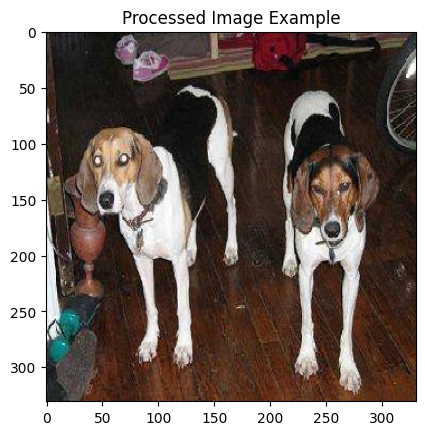

In [ ]:
# Initialize an ImageDataGenerator with specific augmentation and preprocessing options
train_datagen = ImageDataGenerator(
    rescale=1./255.,           #Rescale the pixel values from [0, 255] to [0, 1] for neural network suitability
    horizontal_flip=True,      #Randomly flip images horizontally to increase dataset diversity
    validation_split=0.02      #Reserve 2% of the images for validation
)

#Train data from train folder.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size,
    color_mode="rgb"
)

#Generate validation data from the reserved 2% subset of the training data.
test_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=image_size,
    color_mode="rgb"
)

# Fetch a batch of images and labels from the training generator
x_batch, y_batch = next(train_generator)

# Check if the batch is not empty
if x_batch.size > 0:
    # Select the first image in the batch
    image = x_batch[1]
    # Convert the rescaled image pixel values back to the 0-255 range for visualization
    image = (image * 255).astype('uint8')
    # Display the image
    plt.imshow(image)
    plt.title("Processed Image Example")
    plt.axis('on')
    plt.show()
else:
    print("No images were loaded. Check your dataset configuration.")

# Create NASNet Large Model

In [ ]:
#Initialise NASNetLarge with ImageNet weights, no top layer.
pretrained_model = tf.keras.applications.NASNetLarge(
    weights='imagenet',
    include_top=False,
    input_shape=shape
)
# Freeze the pre-trained model weights to prevent them from being updated during training
pretrained_model.trainable = False

# Start building the model with NASNetLarge as the base.
model = tf.keras.Sequential([
    pretrained_model, # Base model with NASNetLarge
    tf.keras.layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensionality
    tf.keras.layers.Dense(120, activation='softmax') # Output layer for 120-class classification
])

# Initialise optimizer with learning rate and momentum
opt = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

#Compile the model with optimiser, loss, and accuracy metric
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Output a summary
model.summary()



343610240/343610240 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 120)               483960    
                                                                 
Total params: 85400778 (325.78 MB)
Trainable params: 483960 (1.85 MB)
Non-trainable params: 84916818 (323.93 MB)
_________________________________________________________________


# Train the Model

In [ ]:
#Set the number of training cycles through the dataset.
epochs = 10

#Set up early stopping to prevent overfitting.
early = tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.001, restore_best_weights=True)

#Calculate the number of steps per epoch for training.
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

#Calculate the number of steps per epoch for validation.
STEP_SIZE_VALID = test_generator.n // test_generator.batch_size

#Start training the model, using the training and validation data generators.
history2 = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=epochs,
    callbacks=[early],
)


Epoch 1/10
313/313 [==============================] - 303s 886ms/step - loss: 3.8828 - accuracy: 0.5629 - val_loss: 3.0494 - val_accuracy: 0.8594
Epoch 2/10
313/313 [==============================] - 275s 879ms/step - loss: 2.1382 - accuracy: 0.9110 - val_loss: 1.6578 - val_accuracy: 0.9062
Epoch 3/10
313/313 [==============================] - 269s 858ms/step - loss: 1.1435 - accuracy: 0.9259 - val_loss: 0.9787 - val_accuracy: 0.9219
Epoch 4/10
313/313 [==============================] - 279s 890ms/step - loss: 0.7145 - accuracy: 0.9319 - val_loss: 0.6708 - val_accuracy: 0.9323
Epoch 5/10
313/313 [==============================] - 274s 874ms/step - loss: 0.5263 - accuracy: 0.9344 - val_loss: 0.5082 - val_accuracy: 0.9427
Epoch 6/10
313/313 [==============================] - 274s 876ms/step - loss: 0.4308 - accuracy: 0.9360 - val_loss: 0.4530 - val_accuracy: 0.9375
Epoch 7/10
313/313 [==============================] - 275s 878ms/step - loss: 0.3735 - accuracy: 0.9373 - val_loss: 0.4032 -

# Dispaly the Loss and Accuracy curves

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('Epochs')
    ax.legend(['Training', 'Validation'])

display_training_curves(
    history2.history['loss'],
    history2.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history2.history['accuracy'],
    history2.history['val_accuracy'],
    'ACCURACY',
    212,
)

# Test the accuracy

In [ ]:
score = model.evaluate(test_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100))
print("Loss: ",score[0])

7/7 [==============================] - 8s 1s/step - loss: 0.3000 - accuracy: 0.9461
Accuracy: 94.61%
Loss:  0.3000018298625946


# Save the Model

In [ ]:
!mkdir '/content/model'
model.save('/content/model')

# Convert to TFLite Model

In [ ]:
!mkdir '/content/tflite'
saved_model_dir = '/content/model'
tflite_model_path = '/content/tflite/model.tflite'
# Convert the model
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

#Get the labels.txt

In [ ]:
#Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Write class names to a text file
with open('labels.txt', 'w') as f:
    for class_name in class_names:
        f.write(class_name + '\n')



In [ ]:
import json

#class names to json
class_names=train_generator.class_indices
f = open("classes.json", "a")
f.write(json.dumps(class_names))
f.close()

# Test the images from test dir

In [ ]:
# Load a batch of training images and labels
images, labels = test_generator.next()
# Calculate the number of rows and columns for subplots
num_rows = len(images) // 3 + (1 if len(images) % 3 != 0 else 0)
num_cols = min(len(images), 3)

# Display the images along with their corresponding labels
plt.figure(figsize=(15, 5 * num_rows))
for i in range(len(images)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(list(train_generator.class_indices.keys())[np.argmax(labels[i])]))
    plt.axis('on')
plt.tight_layout()
plt.show()

